# Read in the data

In [1]:
import pandas
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score', 'Num of SAT Test Takers']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [35]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

                                 Num of SAT Test Takers  \
Num of SAT Test Takers                         1.000000   
SAT Critical Reading Avg. Score                0.444268   
SAT Math Avg. Score                            0.532834   
SAT Writing Avg. Score                         0.446539   
sat_score                                      0.485338   

                                 SAT Critical Reading Avg. Score  \
Num of SAT Test Takers                                  0.444268   
SAT Critical Reading Avg. Score                         1.000000   
SAT Math Avg. Score                                     0.929221   
SAT Writing Avg. Score                                  0.982826   
sat_score                                               0.986820   

                                 SAT Math Avg. Score  SAT Writing Avg. Score  \
Num of SAT Test Takers                      0.532834                0.446539   
SAT Critical Reading Avg. Score             0.929221                0.982826

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

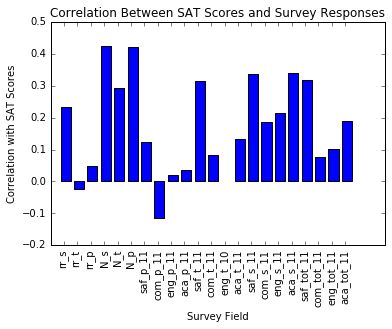

In [11]:
fields=survey_fields[1:]
bar_heights = correlations.ix[fields]
bar_positions = np.arange(len(fields)) + 0.75
tick_positions = range(1,len(fields)+1)

fig, ax = plt.subplots()

ax.bar(bar_positions, bar_heights, .75)
ax.set_xticks(tick_positions)
ax.set_xticklabels(fields, rotation=90)
plt.xlabel('Survey Field')
plt.ylabel('Correlation with SAT Scores')
plt.title('Correlation Between SAT Scores and Survey Responses')
plt.show()

We see the values with the strongest correlation are N_s and N_p, which are the number of student and parent respondents, respectively. This seems to indicate schools with more students tend to have higher SAT scores. 

We also note a significant positive correlation with safety (saf), where students', teachers' and parents' sense of safety carry roughly the same r-value. Student academic expectations (aca_s) also demonstrate a significant correlation, though parental expectations show no correlation. This would imply that students' expectations of themselves are a stronger indicator of performance on the SAT, regardless of what a parent thinks. 

Strangely, the student response rate (rr_s) shows a much stronger correlation to SAT performance compared to teachers and parents. This may be a result of a higher concentration of motivated students, who are also more likely to take the time to fill out a survey. We also saw that schools with more foreign-born students are less likely to do well on the SAT. Perhaps these schools also have lower response rates, as the students may struggle with comprehension on a survey as well.

The most surprising result is that communication scores from students show a slight positive correlation (com_s, nearly .2) , while communication scores from parents show a slight negative correlation (com_p, just below -.1). While both values only show a slight correlation, the difference between them seems to demonstrate a contrast in communication experiences between students and their parents. 

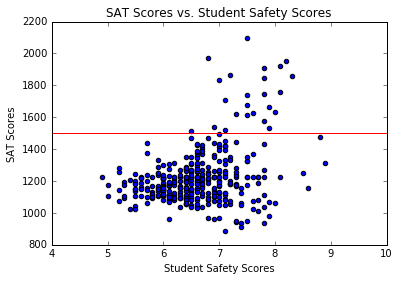

In [12]:
x_ax = combined.saf_s_11
y_ax = combined.sat_score

fig, ax = plt.subplots()
ax.scatter(x_ax,y_ax)
ax.set_xlabel('Student Safety Scores')
ax.set_ylabel('SAT Scores')
ax.set_title('SAT Scores vs. Student Safety Scores')
ax.axhline(y=1500, color='red')
plt.show()

There appear to be two trends in the plot. We see that a relatively small number of schools with very high SAT Scores are influencing our correlation value. More schools with high safety scores demonstrate average performance. It's interesting to note that the schools with the lowest SAT scores (below 1000) tend to have relatively high safety scores as well. Those on the lower end in terms of sense of student safety seem to fall within the average range of NYC SAT scores, looking at the large cluster scoring between 1000 and 1300. When this data was released the [average SAT score was 1500](http://blog.prepscholar.com/what-is-a-good-sat-score-a-bad-sat-score-an-excellent-sat-score), indicated by the horizontal line (total points have been reduced and the new national average is 1000). This invites further discussion about the efficacy of NYC's school system compared to the rest of the U.S., but we'll leave that for another time. At the very least, it seems that while safety is a factor in predicting SAT performance to an extent, above a certain threshold there's generally no relationship between sense of safety among students and test performance.

In order to explore this further, let's take a geographic view of the data.

In [13]:
districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,87.166667,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,120.890672,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,132.781343,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,102.571429,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,93.160768,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


In [14]:
from mpl_toolkits.basemap import Basemap

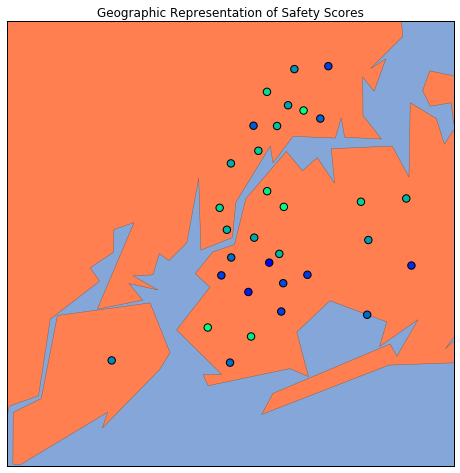

In [15]:
plt.figure(figsize=(8,8))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.fillcontinents(color='coral')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)


longitudes = districts.lon.tolist()
latitudes = districts.lat.tolist()

# For our colormap blue indicates a lower safety score, while green indicates higher scores.
m.scatter(x=longitudes, y=latitudes, s=55, zorder=2, latlon=True, c=districts["saf_s_11"], cmap="winter")
plt.title("Geographic Representation of Safety Scores")
plt.show()

### Location, Location, Location

Brooklyn school districts, the collection of dark blue points in the middle of the map, show almost uniformly low safety scores relative to the average response, with two notable exceptions in South Brooklyn, near . Northwest Queens districts scores highly for safety, though as a whole New York's largest borough by landmass varies greatly in safety ratings. Manhattan tends to show an above average safety score. We note strong variability despite high concentration in the Bronx. 



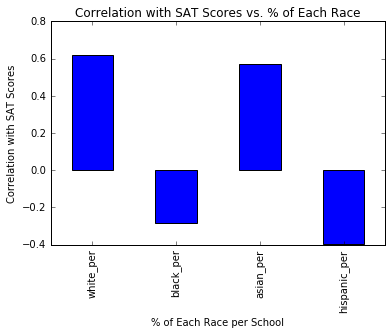

In [16]:
race_per = ['white_per', 'black_per', 'asian_per', 'hispanic_per']

bar_heights = correlations.ix[race_per]
bar_pos = np.arange(4) + 0.75
tick_pos = range(1, 5)

fig, ax = plt.subplots()

ax.bar(bar_pos, bar_heights, .5)
ax.set_xticks(tick_pos)
ax.set_xticklabels(race_per, rotation=90)
ax.set_xlabel('% of Each Race per School')
ax.set_ylabel('Correlation with SAT Scores')
plt.title('Correlation with SAT Scores vs. % of Each Race')
plt.show()

We find a strong positive correlation between SAT scores and the percentage of asian and white students at a school. The percentage of hispanic students has a notable negative correlation, and the percentage of black students shows a slightly weaker correlation than that of hispanics. While this may initially point to Enlish ability as an indicator of SAT performance, that would neglect the fact that many asian students may be learning English as well. Let's dive into the data and see what we find.

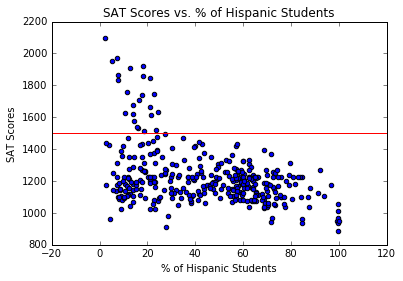

In [17]:
x_ax = combined.hispanic_per
y_ax = combined.sat_score

fig, ax = plt.subplots()
ax.scatter(x=x_ax, y=y_ax)
ax.axhline(y=1500, color='red')
ax.set_xlabel('% of Hispanic Students')
ax.set_ylabel('SAT Scores')
plt.title('SAT Scores vs. % of Hispanic Students')
plt.show()

The schools with the highest SAT scores (and every school above the national avereage) have fewer than 25% hispanic student populations. This is a significant fact, and demonstrates great inequality in the SAT for hispanic students. Those schools with ~100% hispanic populations all had average scores below 1100. We note two strong clusters, one of schools with hispanic percentages between 55% and 70% and another between 5% and 20%. Both of these clusters fall within the same range of scores.

In [18]:
over95 = combined[combined['hispanic_per'] >= 95.]
print(over95['SCHOOL NAME'], '\n', over95['sat_score'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object 
 44     1058.0
82     1174.0
89     1014.0
125     951.0
141     934.0
176     970.0
253     887.0
286     951.0
Name: sat_score, dtype: float64


All of the schools with a percentage of hispanic students above 95% are transition schools for immigrants. Two are in Manhattan, three are in the bronx, one is in Brookly and one is in Queens. Washington Heights School focuses on students from the Dominican Republic and Dominican Americans. Gregorio Luperon was originally a transitional program that later transitioned into a full-fledged 4-year high school. The Academy for Language and Technology only admits spanish speaking students that have been in the U.S. for less than 4 years, the Internation School for Liberal Arts has a mission statement geared towards the strength of bilingual education, and Pan American International is a college preparatory school for Spanish speakers learning English. In total, we find that schools with very high concentrations of hispanic students tend to focus on helping immigrants learn English and succeed in American society. We also find that these schools tend to have very low SAT scores, which makes sense given the language barrier. 

In [19]:
under10 = combined[combined['hispanic_per'] < 10]
under10 = under10[under10['sat_score'] > 1450]
print(under10['SCHOOL NAME'],'\n', under10.sat_score)
print(under10['Num of SAT Test Takers'])
print(under10['N_s'])
print('Avg. # of SAT Test Takers, scores over 1500: ', combined[combined.sat_score >= 1500]['Num of SAT Test Takers'].mean())
print('Avg. # of SAT Test Takers, top 5 schools: ', (832+731+1277+121+227)/5)
print('Avg. # of student survey responses, complete set: ', combined['N_s'].mean())

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object 
 37     2096.0
151    1969.0
187    1833.0
327    1868.0
356    1953.0
Name: sat_score, dtype: float64
37      832.0
151     731.0
187    1277.0
327     121.0
356     227.0
Name: Num of SAT Test Takers, dtype: float64
37     3039.0
151    2956.0
187    4768.0
327     399.0
356    1003.0
Name: N_s, dtype: float64
Avg. # of SAT Test Takers, scores over 1500:  289.416666667
Avg. # of SAT Test Takers, top 5 schools:  637.6
Avg. # of student survey responses, complete set:  598.208333333


In [20]:
pandas.to_numeric(combined['Num of SAT Test Takers']).mean()

128.12537313432836

Only 5 schools have a hispanic population under 5% and average SATs above 1450. Unsurprisingly, they're 4 of the 9 "specialized high schools" in NYC. All 4 are publicly funded technical schools, highly focused on Science, Technology, Engineering and Mathematics (STEM) disciplines. These schools account for just over a fifth of the 24 schools with average SAT's above 1500. At a glance we note that these schools also have a much higher number of survey respondents than average. Amongst all schools with average SAT scores above 1500 the top 5 tend to have more students taking tests, and it's worth noting that Queens High School formed in 2002 and Staten Island Technical School formed in 1988. This is likely the primary factor when looking at the difference in number of test takers. The next youngest school is The Bronx High School of Science, which was founded in 1938. Without Queens and Staten Island, the average number of test takers is 309 students higher. 

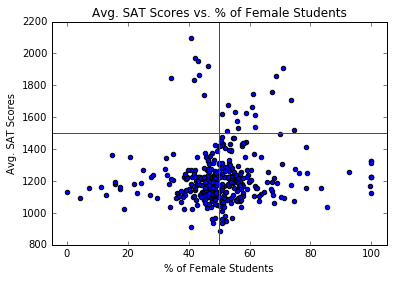

In [44]:
#fig = plt.figure(figsize=(5,10))
#ax1 = fig.add_subplot(1,1,1)
#ax2 = fig.add_subplot(2,1,2)

fig, ax1 = plt.subplots()
y_ax = combined["sat_score"]

x_ax = combined["female_per"]
ax1.scatter(x_ax, y_ax)
ax1.axhline(y=1500, color='red')
#ax1.axhline(y=1700, color='black')
ax1.axvline(x=50, color='green')
ax1.set_ylabel('Avg. SAT Scores')
ax1.set_xlabel('% of Female Students')
ax1.set_xlim(-5,105)
ax1.set_title('Avg. SAT Scores vs. % of Female Students')

#x_ax = combined["female_per"]
#ax2.scatter(x_ax, y_ax)
#ax2.set_ylabel('Avg. SAT Scores')
#ax2.set_xlabel('% of Female Students')
#ax2.set_xlim(-5,105)
#ax2.set_title('Avg. SAT Scores vs. % of Female Students')

plt.show()

There's no obvious correlation between the percentage of either sex and SAT scores. There are more schools with majority female students that score above the national average, however schools scoring above 1700 tend to have more male students. Let's look at these high scoring schools by percentage of each sex.

In [77]:
fem_majority = combined[combined.female_per > 60.]
fem_majority = fem_majority[fem_majority.sat_score > 1700]
print(fem_majority["SCHOOL NAME"])
print(fem_majority.sat_score)
print(fem_majority.female_per)

male_majority = combined[combined.male_per > 55.]
male_majority = male_majority[male_majority.sat_score > 1700]
print(male_majority["SCHOOL NAME"])
print(male_majority.sat_score)
print(male_majority.male_per)

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object
5      1856.0
26     1758.0
60     1744.0
61     1707.0
302    1910.0
Name: sat_score, dtype: float64
5      68.7
26     67.5
60     61.0
61     73.6
302    71.1
Name: female_per, dtype: float64
37                                STUYVESANT HIGH SCHOOL
79     HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object
37     2096.0
79     1847.0
151    1969.0
187    1833.0
327    1868.0
356    1953.0
Name: sat_score, dtype: floa

We find that high schools with students performing well on the SAT and majority female enrollment tend to be humanities focused. Laguardia is the only school of the aforementioned 9 elective schools that doesn't require a test for entrance. Instead, they hold auditions for various performance art categories. Beacon School was once notable for completely neglecting the traditional NYC high school graduation procedure in favor of portfolio-based assessment. Townsend Harris is more humanities focused and tends to have stringent entry standards. It also introduced the college-level curriculum blend later adapted by Queens High. Laguardia is the only school of the nine selective NYC high schools that requires auditions for admissions, as opposed to a standardized exam. Eleanor Roosevelt is a small class college prep school, consistently ranked among the best high schools in the country. Interestingly, Townsend Harris is the only school here not located in Manhattan.

## Men are from Jupiter, Women are from Mars
Of the schools performing exceptionally on the SAT, majority female schools tend to focus on the humanities while majority male schools tend to focus on STEM fields. The average SAT score for male dominated schools are higher, though of those schools the difference in male and female percentages tend to be less than those of schools with a majority female population. When considering schools with majority male students and average SAT scores above 1700, only one institution appears with a hispanic population above the previous limit, _the High School for Mathematics Science and Engineering_. 

In [99]:
print(combined.iloc[79].hispanic_per)
print(combined[combined.sat_score > 1500]['hispanic_per'].mean())

21.2
15.1916666667


HSMSE has a 21% hispanic population and the second lowest SAT score among the top 6 male-majority institutions, with an average SAT of 1847. For schools scoring above 1500, the average share of hispanic students was 15%. This indicates HSMSE is an outlier in terms of SAT performance compared to percentage of hispanic students.

In [108]:
ap_per = combined['AP Test Takers ']/combined['total_enrollment']
ap_scores = combined['Number of Exams with scores 3 4 or 5']

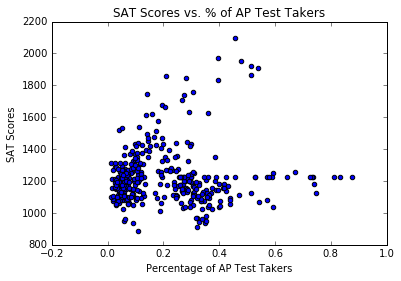

In [109]:
fig, ax = plt.subplots()
ax.scatter(x=ap_per, y=combined['sat_score'])
ax.set_xlabel("Percentage of AP Test Takers")
ax.set_ylabel("SAT Scores")
plt.title('SAT Scores vs. % of AP Test Takers')
plt.show()

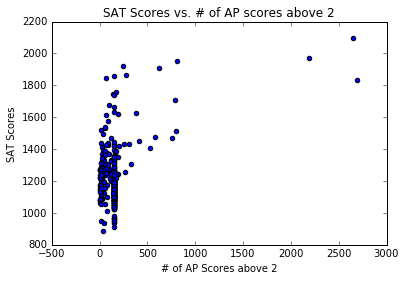

In [110]:
fig, ax = plt.subplots()
ax.scatter(x=ap_scores, y=combined['sat_score'])
ax.set_xlabel("# of AP Scores above 2")
ax.set_ylabel("SAT Scores")
plt.title('SAT Scores vs. # of AP scores above 2')
plt.show()

In [118]:
#np.median(ap_scores)
#np.mean(ap_scores)
ap_scores.describe()

count     363.000000
mean      153.450000
std       239.117292
min         6.000000
25%        76.000000
50%       153.450000
75%       153.450000
max      2687.000000
Name: Number of Exams with scores 3 4 or 5, dtype: float64